# Artificial Neural Network to distinguish chest CT image

### Training model for production with all images

Model was trained to distinguish 3 classes: (A) CT of the chest, (B) CT of other parts of the body and (C) any images
- Convolutional Neural network
- Transferlearning: VGG16 from the kernel 56
- Each fold a new VGG16 was inserted
- batch_size = 10
- image shape = 224, 224
- epoch = 10

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import glob, os
from sklearn.model_selection import KFold
import datetime
import multiclass_metrics
import matplotlib.pyplot as plt

### Dataset description

In [2]:
split = pd.read_csv('split_train_val_test.csv',index_col = [0])
split.index = ['chest_tc','others_tc','no_tc']
split['Training'] = split.sum(axis=1)
split.loc['Total'] = split.sum()
del split['Train'], split['Train %'], split['Validation'], split['Validation %'], split['Test'], split['Test %']

split['Training (%)'] = ['%.1f' % (split.loc['chest_tc','Training'] / split.loc['Total','Training']*100),
                        '%.1f' % (split.loc['others_tc','Training'] / split.loc['Total','Training']*100),
                        '%.1f' % (split.loc['no_tc','Training'] / split.loc['Total','Training']*100),
                        '%.1f' % (split.loc['Total','Training'] / split.loc['Total','Training']*100)]

split

,Training,Training (%)
chest_tc,137930,34.1
others_tc,147598,36.5
no_tc,118387,29.3
Total,403915,100.0


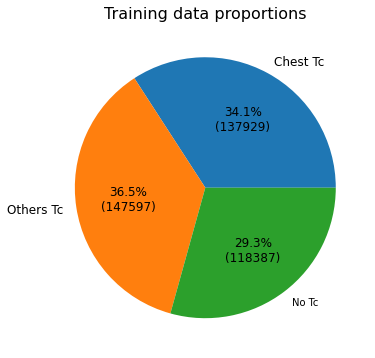

In [3]:

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

sum_chest_tc = split['Training']['chest_tc']
sum_others_tc = split['Training']['others_tc']
sum_no_tc = split['Training']['no_tc']

recipe = [str(sum_chest_tc), str(sum_others_tc), str(sum_no_tc)]
data = [float(x.split()[0]) for x in recipe]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, labels=['Chest Tc','Others Tc','No Tc'], autopct=lambda pct: func(pct, data), textprops=dict(color="k"))
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)

plt.setp(autotexts, size=12)
# plt.legend(labels=group_names,loc="best")
ax.set_title("Training data proportions", size=16)
plt.show()

### Import VGG16 pre-trained model

In [4]:
img_width, img_height = 224, 224 
batch_size = 10

vgg16 = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
display(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

None

### Freezing layers of VGG16 before the kernel 56

In [5]:
for layer in vgg16.layers[:-12]: layer.trainable = False

for layer in vgg16.layers: print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f650864cad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f650864cf90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f65096c5e50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f664b826b10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6506581ad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f650957f750> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f65044cd810> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f65044db950> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f65044db910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f65044e5490> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f65044ebe50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

### Dataframe for flow_from_directory

In [6]:
dataframe = pd.read_csv('dataframe.csv')
dataframe

,id,label
0,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
1,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
2,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
3,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
4,/scratch/v_project/diagnosticos/pre_processing...,chest_tc
...,...,...
403610,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403611,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403612,/scratch/v_project/diagnosticos/pre_processing...,no_tc
403613,/scratch/v_project/diagnosticos/pre_processing...,no_tc


In [ ]:
model_name = 'valid_CT_model'

epochs = 10 

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=dataframe,
directory="./train/",
x_col="id",
y_col="label",
subset="training",
batch_size=batch_size,
shuffle=False,
class_mode="categorical",
target_size=(img_width, img_height))

num_classes = len(train_generator.class_indices) 
print('Quantidade de classes:',num_classes)
# get the class labels for the training data, in the original order 
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

In [ ]:
#create the model
model = Sequential()
#Add the vgg convolutional base model
model.add(vgg16)
#ADd new layers
model.add(Flatten()) 
model.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

display(model.summary())

# Backlog parameters
log_filepath = os.path.join('./out/log',model_name)
os.makedirs(log_filepath, exist_ok=True)
                            
csv_log = CSVLogger(os.path.join(log_filepath, model_name + '.log'))                                   

callbacks_path = os.path.join('./out/H5',model_name)
os.makedirs(callbacks_path,exist_ok=True)

filepath=(os.path.join(callbacks_path,model_name + '_{epoch:02d}_AC{acc:.3f}_L{loss:.5f}.h5') )


callbacks_list = [ModelCheckpoint(filepath,
                                  monitor='acc',
                                  include_optimizer=False,
                                  save_best_only=True),
                  EarlyStopping(monitor='acc', patience=20, restore_best_weights=True), csv_log]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

history = model.fit(train_generator,
#                     steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                    epochs=epochs,
#                         validation_data=validation_generator,
#                     validation_steps=validation_generator.samples/validation_generator.batch_size,
                    callbacks=callbacks_list,
                    verbose=1)

In [ ]:
#save model
model.save(os.path.join('./H5',model_name,'final_model.h5'))
print('model h5 saved')
# model.save_weights('weights'+top_model_weights_path)

start = datetime.datetime.now()
(train_loss, train_accuracy) = model.evaluate( 
    train_generator,use_multiprocessing=True)
print('[INFO] accuracy: {:.2f}%'.format(train_accuracy * 100)) 
print('[INFO] Loss: {}'.format(train_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time spent evaluating:', elapsed)

#Graphing our training and validation
acc = history.history['acc']
#     val_acc = history.history['val_acc']
loss = history.history['loss']
#     val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14,4))
plt.plot(epochs, acc, 'r', label='Training acc')
#     plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(epochs, loss, 'r', label='Training loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)




In [ ]:
# model = load_model('./H5',model_name,'final_model.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})

In [ ]:
start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)

In [ ]:
save_path = os.path.join('./saida_metricas',rede)

classes = ['Chest TC','No TC','Others TC']
metricas = multiclass_metrics.get_metrics(train_labels, preds, class_names=classes,save_path=save_path)
display(metricas)

multiclass_metrics.plot_graphics(train_labels,preds, class_names=classes,save_path=save_path)

# print('Métricas')
# display(metricas)